In [1]:
from dataclasses import dataclass, field
from typing import Optional
import sys
sys.path.append('/scratch/2023-fall-sp-le/langseg')

import torch
from torch import nn
from torch.nn import functional as F
torch.backends.cuda.matmul.allow_tf32 = True
from transformers import CLIPProcessor, CLIPModel
from diffusers import StableDiffusionPipeline

import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
from  matplotlib import pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
from methods.prompt_engineering import extract_class_embeddings, extract_clip_text_embeddings
BICUBIC = InterpolationMode.BICUBIC

from datasets.coco_stuff import coco_stuff_categories
from datasets.cityscapes import cat_to_label_id as cityscapes_cats
from datasets.utils import get_dataset
from utils.metrics import RunningScore
from utils.plotting import *

from methods.diffusion_patch import *
from methods.diffusion import *
from methods.diffusion_seg import *
from methods.diffusion_utils import *
from methods.text_embeddings import *
from methods.multilabel_classifiers import *
from methods.diffseg import *
from methods.exp_utils import *

%load_ext autoreload
%autoreload 2

In [2]:
@dataclass
class SegmentationConfig:
    dir_dataset: str = field(
        default="/scratch/2023-fall-sp-le/data/VOCdevkit/VOC2010", metadata={"help": "dir dataset"}
    )
    dataset_name: str = field(
        default="pascal_context", metadata={"help": "for get_dataset"}
    )
    split: str = field(
        default="train", metadata={"help": "which split to use"}
    )
    resolution: int = field(
        default=512, metadata={"help": "resolution of the images, e.g, 512, 768, 1024"}
    )
    mask_res: int = field(
        default=320, metadata={"help": "resolution of the masks, e.g, 64, 320, 512"}
    )
    dense_clip_arch: str = field(
        default="RN50x16", metadata={"help": "not used in cocostuff"}
    )

args = SegmentationConfig()

In [3]:
dataset, categories, palette = get_dataset(
    dir_dataset=args.dir_dataset,
    dataset_name=args.dataset_name,
    split=args.split,
    resolution=args.resolution,
    mask_res=args.mask_res,
    dense_clip_arch=args.dense_clip_arch
)

if args.dataset_name == "coco_stuff":
    label_id_to_cat = categories if not dataset.use_27 else coco_stuff_categories
    cat_to_label_id = {v: i for i, v in enumerate(label_id_to_cat)}
elif args.dataset_name == "cityscapes":
    cat_to_label_id = cityscapes_cats
    label_id_to_cat = {i: c for c, i in cat_to_label_id.items()}
elif args.dataset_name == "voc2012" or args.dataset_name == "pascal_context":
    label_id_to_cat = categories
    cat_to_label_id = {v: i for i, v in enumerate(label_id_to_cat)}

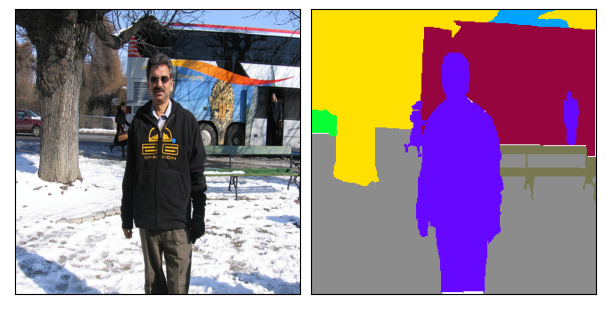

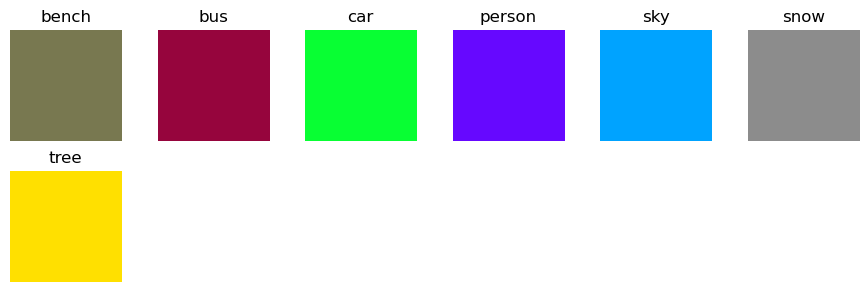

In [4]:
idxx = 58
val_img = dataset[idxx]["img"].cpu().numpy()
val_gt = dataset[idxx]["gt"].cpu().numpy()
lab_ids = sorted(list(np.unique(val_gt)))
lab_ids = np.array(lab_ids[1:])
val_pil_img = render_results(val_img, val_gt, palette)
_ = get_legends(lab_ids, palette, label_id_to_cat, is_voc2012 = args.dataset_name == "voc2012")

val_gt = dataset[idxx]["gt"].unsqueeze(0)
val_labels = sorted(np.unique(val_gt))
val_labels = [l for l in val_labels if l != -1] # don't process label -1 (ignored unlabelled pixels)
val_labels = [label_id_to_cat[c] for c in val_labels]
val_labels = [l for l in val_labels if l != "background"] # don't feed "background" as text input

In [5]:
import torch
from methods import gem
import requests
from PIL import Image

# model_name = 'ViT-B/16'  # 'ViT-B-16-quickgelu'
# pretrained = 'openai'  # 'metaclip_400m'
model_name = 'ViT-B/16-quickgelu'
# model_name = 'ViT-L/14-quickgelu'
pretrained = 'metaclip_400m'
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# init model and image transform
gem_model = gem.create_gem_model(model_name=model_name,
                                 pretrained=pretrained, 
                                 device=device)

In [6]:
model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16,
    use_safetensors=True, variant="fp16",
    # device_map="auto"
)
pipe = pipe.to("cuda")
configure_ldm(pipe)

handles = {}
attention_layers_to_use = ATTENTION_LAYERS
attention_store = AttentionStore(low_resource=False, no_uncond=True, layer_keys=attention_layers_to_use)
attention_store.num_att_layers = len(attention_layers_to_use)
handles = register_attention_hooks(pipe.unet, attention_store, attention_layers_to_use, handles)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [7]:
# def get_image_and_labels(idx):
#     img_path = dataset[idx]["p_img"]
#     image = Image.open(img_path).convert('RGB').resize((1024, 1024))
#     val_gt = dataset[idx]["gt"].cpu().numpy()
#     val_labels = sorted(np.unique(val_gt))
#     val_labels = np.array([l for l in val_labels if l > 0])
#     y_true = np.zeros((len(label_id_to_cat),), dtype=np.int64)
#     y_true[val_labels] = 1
#     return image, y_true


# def get_pred_label_names(y_pred, candidate_labels):
#     label_preds = np.array(candidate_labels)[y_pred.astype(bool)]
#     assert len(label_preds) > 0
#     return label_preds.tolist()


# # clip_model_id = "openai/clip-vit-large-patch14"
# clip_model_id = "facebook/metaclip-h14-fullcc2.5b"
# clip_classifier = CLIPMultilabelClassifier(clip_model_id, label_id_to_cat)

# # del clip_classifier.clip_model.text_model
# # clip_classifier.clip_model.to(pipe.text_encoder.dtype)
# # clip_classifier.clip_model.text_model = pipe.text_encoder.text_model

# clip_classifier.init_text_embeds()
# del clip_classifier.clip_model.text_model

In [8]:
# # load image and text
# preprocess = gem.get_gem_img_transform(img_size=(448, 448))
# image = preprocess(Image.open(dataset[idxx]["p_img"])).unsqueeze(0).to(device)
# class_names = label_id_to_cat#[1:]
# with torch.no_grad():
#     logits = gem_model(image, class_names, normalize=False, return_ori=False)  # [1, num_class, W, H]

In [9]:
# normed_logits = gem_model.min_max(logits)
# gem.visualize(image, class_names, normed_logits)  # (optional visualization)

In [10]:
def run_gem_voc():
    preprocess = gem.get_gem_img_transform(img_size=(448, 448))
    pbar = tqdm(range(len(dataset)))

    rscores = [RunningScore(len(label_id_to_cat)) for i in range(7)]

    cls_gt = []
    cls_pred_0 = []
    cls_pred_2 = []

    # 0: CA @ SA
    # 1: CA @ SA & GT class names
    # 2: CA only
    # 3: CA only & GT class names
    # 4: labeling GT clusters with cluster-avg CA
    # 5: labeling diffseg clusters with cluster-avg CA
    # 6: labeling specclust clusters with cluster-avg CA
    for idx in pbar:
        val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
        val_gt = dataset[idx]["gt"].unsqueeze(0)
        val_labels = sorted(np.unique(val_gt))
        val_labels = [l for l in val_labels if l != -1] # don't process label -1 (ignored unlabelled pixels)
        val_labels = [label_id_to_cat[c] for c in val_labels]
        val_labels = [l for l in val_labels if l != "background"] # don't feed "background" as text input

        # # multilabel classification (does not work)
        # image, y_true = get_image_and_labels(idx)
        # y_pred, _ = clip_classifier.forward_v2(image, choice=(8,8), clf_thresh=0.25)
        # y_pred = y_pred.cpu().numpy()
        # val_labels = get_pred_label_names(y_pred, label_id_to_cat)

        # load image and text
        image = preprocess(Image.open(dataset[idx]["p_img"]).convert("RGB")).unsqueeze(0).to(device)
        class_names = label_id_to_cat

        with torch.no_grad():
            logits01 = gem_model(image, class_names, output_size=64, normalize=False)  # [1, num_class, W, H]

        # CA only
        logits23456 = F.interpolate(logits01, size=320, mode='bilinear')
        logits23456 = (logits23456*100).softmax(dim=1)
        pred2 = logits23456.argmax(dim=1)
        pred3 = filter_prompt(logits23456, val_labels, cat_to_label_id).argmax(dim=1)
        pred4 = label_clusters(val_gt, logits23456)

        # CA @ SA
        val_img = dataset[idx]["img"].permute(1,2,0)[None,...].numpy()
        attention_store.reset()
        text_embeds = get_text_embeddings_simple(pipe.tokenizer, pipe.text_encoder, "")
        val_img = val_img.repeat(len(text_embeds), axis=0)
        training_step(pipe, text_embeds, val_img, attention_store, no_uncond=True, normalize=False, low_resource=False, timestep=100)
        ca, sa = get_attention_maps(
            attention_store.get_average_attention(),
            batch_size=len(text_embeds),
            label_indices=None,
            output_size=64,
            average_layers=True,
            apply_softmax=True,
            softmax_dim=-1,
            simple_average=False
        )
        pred5 = diffseg(sa, refine=True)
        pred5 = label_clusters(pred5, logits23456)
        pred6 = get_specclust_mask(
            logits23456.permute(0, 2, 3, 1).view(1, -1, logits23456.shape[1]), sa, cat_to_label_id,
            list(range(len(label_id_to_cat))), label_id_to_cat,
            output_size=args.mask_res, minmax_norm=False
        ).long()
    
        ca0 = (logits01 * 100).softmax(dim=1)
        ca0 = ca0.view(*ca0.shape[:2], -1).permute(0, 2, 1)
        agg_map0 = get_agg_map(ca0, sa, minmax_norm=False, ca_norm=False)
        agg_map0 = upscale_attn(agg_map0, 320)
        pred0 = agg_map0.argmax(dim=-1)

        ca1 = (filter_prompt(logits01, val_labels, cat_to_label_id) * 100).softmax(dim=1)
        ca1 = ca1.view(*ca1.shape[:2], -1).permute(0, 2, 1)
        agg_map1 = get_agg_map(ca1, sa, minmax_norm=False, ca_norm=False)
        agg_map1 = upscale_attn(agg_map1, 320)
        pred1 = agg_map1.argmax(dim=-1)
        
        # multilabel classification
        cls_gt.append(val_gt.unique().tolist())
        cls_pred_0.append(pred0.unique().tolist())
        cls_pred_2.append(pred2.unique().tolist())

        for rs, pred in zip(rscores, [pred0, pred1, pred2, pred3, pred4, pred5, pred6]):
            rs.update(val_gt.cpu().numpy(), pred.cpu().numpy())

        mious = []
        for rs in rscores:
            metrics, _ = rs.get_scores()
            mious.append(metrics["Mean IoU"])

        description = " | ".join([f"mIoU_{i} {mious[i]:.3f}" for i in range(len(mious))])
        pbar.set_description(description)

    return rscores, (cls_gt, cls_pred_0, cls_pred_2)

with np.errstate(divide='ignore', invalid='ignore'):
    rs, cls_multilabel = run_gem_voc()

mIoU_0 0.378 | mIoU_1 0.512 | mIoU_2 0.365 | mIoU_3 0.505 | mIoU_4 0.449 | mIoU_5 0.367 | mIoU_6 0.373: 100%|██████████| 4996/4996 [3:23:17<00:00,  2.44s/it]  


train: mIoU_0 0.378 | mIoU_1 0.512 | mIoU_2 0.365 | mIoU_3 0.505 | mIoU_4 0.449 | mIoU_5 0.367 | mIoU_6 0.373

val: mIoU_0 0.386 | mIoU_1 0.516 | mIoU_2 0.373 | mIoU_3 0.510 | mIoU_4 0.458 | mIoU_5 0.374 | mIoU_6 0.383

In [11]:
for i in range(len(rs)):
    metrics, cls_iou = rs[i].get_scores() # original results
    print({k: f"{v*100:.1f}" for k, v in metrics.items()})
    print({label_id_to_cat[i]: f"{v*100:.1f}" for i, v in cls_iou.items()})
    print("#" * 100)

{'Pixel Acc': '63.1', 'Mean Acc': '56.6', 'FreqW Acc': '50.5', 'Mean IoU': '37.8'}
{'aeroplane': '62.7', 'bag': '17.8', 'bed': '7.6', 'bedclothes': '33.5', 'bench': '9.1', 'bicycle': '64.0', 'bird': '79.9', 'boat': '42.9', 'book': '7.9', 'bottle': '70.4', 'building': '27.2', 'bus': '71.4', 'cabinet': '27.3', 'car': '73.4', 'cat': '86.0', 'ceiling': '32.4', 'chair': '35.4', 'cloth': '7.6', 'computer': '7.5', 'cow': '72.1', 'cup': '15.8', 'curtain': '37.4', 'dog': '80.3', 'door': '18.0', 'fence': '30.1', 'floor': '49.2', 'flower': '23.4', 'food': '30.7', 'grass': '57.9', 'ground': '23.0', 'horse': '68.8', 'keyboard': '21.0', 'light': '4.9', 'motorbike': '72.9', 'mountain': '37.6', 'mouse': '0.2', 'person': '68.3', 'plate': '13.8', 'platform': '4.3', 'pottedplant': '45.0', 'road': '24.4', 'rock': '31.1', 'sheep': '76.0', 'shelves': '18.2', 'sidewalk': '7.8', 'sign': '13.2', 'sky': '69.3', 'snow': '46.2', 'sofa': '40.9', 'table': '21.2', 'track': '31.8', 'train': '69.2', 'tree': '52.6', 't

In [12]:
from sklearn.metrics import classification_report, precision_score, recall_score, multilabel_confusion_matrix, accuracy_score

def binarize_multilabel(labels, n_classes):
    # labels: list of list
    label_array = np.zeros((len(labels), n_classes))
    for i, label in enumerate(labels):
        label = [l for l in label if l != -1]
        label_array[i, label] = 1
    return label_array

cls_gt, cls_pred_0, cls_pred_2 = cls_multilabel
y_true = binarize_multilabel(cls_gt, len(label_id_to_cat))
y_pred0 = binarize_multilabel(cls_pred_0, len(label_id_to_cat))
y_pred2 = binarize_multilabel(cls_pred_2, len(label_id_to_cat))

pr0 = precision_score(y_true, y_pred0, average="macro")
rc0 = recall_score(y_true, y_pred0, average="macro")
pr2 = precision_score(y_true, y_pred2, average="macro")
rc2 = recall_score(y_true, y_pred2, average="macro")

print("Average precision 0 {:.3f}, average recall 0 {:.3f}".format(pr0, rc0))
print("Average precision 2 {:.3f}, average recall 2 {:.3f}".format(pr2, rc2))

Average precision 0 0.631, average recall 0 0.540
Average precision 2 0.504, average recall 2 0.674


### train

Average precision 0 0.631, average recall 0 0.540

Average precision 2 0.504, average recall 2 0.674

### val

Average precision 0 0.632, average recall 0 0.553

Average precision 2 0.507, average recall 2 0.685

In [13]:
print(classification_report(y_true, y_pred0))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       283
           1       0.23      0.29      0.25       164
           2       0.26      0.51      0.34        61
           3       0.36      0.53      0.43       136
           4       0.15      0.28      0.20        67
           5       0.92      0.88      0.90       227
           6       0.97      0.85      0.90       339
           7       0.76      0.93      0.84       222
           8       0.59      0.10      0.17       224
           9       0.73      0.44      0.55       284
          10       0.96      0.31      0.47      1507
          11       0.89      0.87      0.88       180
          12       0.42      0.60      0.50       251
          13       0.82      0.68      0.74       523
          14       0.94      0.97      0.96       492
          15       0.70      0.46      0.56       297
          16       0.60      0.57      0.59       468
          17       0.43    

In [14]:
print(classification_report(y_true, y_pred2))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       283
           1       0.16      0.45      0.23       164
           2       0.15      0.80      0.25        61
           3       0.30      0.68      0.41       136
           4       0.08      0.40      0.13        67
           5       0.78      0.93      0.85       227
           6       0.89      0.94      0.91       339
           7       0.58      0.97      0.73       222
           8       0.63      0.23      0.34       224
           9       0.53      0.54      0.53       284
          10       0.86      0.51      0.64      1507
          11       0.77      0.91      0.83       180
          12       0.28      0.80      0.41       251
          13       0.70      0.82      0.76       523
          14       0.90      0.98      0.94       492
          15       0.55      0.69      0.61       297
          16       0.45      0.77      0.56       468
          17       0.31    

In [15]:
def avg_fpr(y_true, y_pred):
    conf_matrices = multilabel_confusion_matrix(y_true, y_pred)

    # Calculate False Positive Rate for each class
    false_positive_rates = []

    for i in range(len(conf_matrices)):
        false_positive_rate = conf_matrices[i][0, 1] / (conf_matrices[i][0, 1] + conf_matrices[i][0, 0])
        false_positive_rates.append(false_positive_rate)

    # Calculate the average false positive rate
    average_false_positive_rate = sum(false_positive_rates) / len(false_positive_rates)

    print("Average False Positive Rate:", average_false_positive_rate)

avg_fpr(y_true, y_pred0)
avg_fpr(y_true, y_pred2)

Average False Positive Rate: 0.022126554052272568
Average False Positive Rate: 0.08353170386021477


### train

Average False Positive Rate: 0.022126554052272568

Average False Positive Rate: 0.08353170386021477

### val

Average False Positive Rate: 0.02215339229597623

Average False Positive Rate: 0.08479405714043442